In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from scipy.stats import norm

#Polynomial Chaos E. terms ----------------------------------------------

def hermite(x,n):
    if n==0:
        return 1
    elif n==1:
        return x
    elif n==2:
        return (x**2-1)/(np.sqrt(2))
    elif n==3:
        return (x**3-3*x)/(np.sqrt(6))
    elif n==4:
        return (x**4-6*x**2+3)/(np.sqrt(24))
    elif n==5:
        return (x**5-10*x**3+15*x)/(np.sqrt(120))

def legendre(x,n):
    if n==0:
        return 1
    elif n==1:
        return x*(np.sqrt(3))
    elif n==2:
        return (3*x**2-1)*(np.sqrt(5))/2
    elif n==3:
        return (5*x**3-3*x)*(np.sqrt(7))/2
    elif n==4:
        return (35*x**4-30*x**2+3)*(np.sqrt(9))/8
    elif n==5:
        return (63*x**5-70*x**3+15*x)*(np.sqrt(11))/8  
    
def scalelegendre(x,new_min,new_max): 
    return ((new_min+new_max)+((new_max-new_min)*x))/2

def scalehermite(x,mean,sigma):
    return mean+sigma*x

def PCE(x,Y_):
    M_= 0
        
    for j in range (0,len(Y_)):
           
        M_ = M_ + Y_[j] * M1(x,j)  #M1 legendre / M2 hermite

    return M_

#Kriging --------------------------------------------------------------

def distance(x,xk):
    return x.reshape(-1,1)-xk.reshape(1,-1)

def euclid(r,l,scale):   #using kernell squared Euclidean distance
    return scale*np.exp(-((r**2)/(2*l**2)))

def GaussianPred(x,xn,yn,F,B):
    COV_nn=euclid(distance(xn,xn),l,sig)
    COV_xn=euclid(distance(x,xn),l,sig)
    COV_mult=np.matmul(COV_xn,np.linalg.inv(COV_nn))
    #-------------------------------------
    COV_xx=euclid(distance(x,x),l,sig)
    mean=np.matmul(COV_mult,(yn-np.matmul(F,B)))
    #-------------------------------------
    variance=np.subtract(COV_xx,np.matmul(COV_mult,COV_xn.transpose()))
    variaDiag=np.diagonal(variance)
    return [mean,variaDiag];

def VoronoiCell(x,xn):   #given x [single value] return the index of the closest xn [1D array]
    dist=abs(distance(x,xn))
    voro=np.argmin(np.squeeze(dist))
    return voro

# adaptive learning - expected feasiability function --------------------------------------------------------------

def EFF1(u,v,z):
    zl=-2*v
    zh=2*v
    return ((u-z)*( 2*norm.cdf((z-u)/v) - norm.cdf((zl-u)/v) - norm.cdf((zh-u)/v)) 
           -(v)*( 2*norm.pdf((z-u)/v) - norm.pdf((zl-u)/v) - norm.pdf((zh-u)/v))  
           +(2*v)*(norm.cdf((zh-u)/v) - norm.cdf((zl-u)/v)))

In [2]:
#function to evaluate -------------------------------------------

def function(x):
    return 2-100*(np.sin(x*7)+np.cos(14*x))*(x**2)*np.exp(-4*x)

In [3]:
n=3       # observations

np.random.seed(0)         #fixing seed for random number 

#-----------------------------------------------------random Variable
M1 = legendre
x1 = np.linspace(-1,1,n)
# x1 = np.random.uniform(-1,1,n)    #uniform
x1min = 0.25                           #lower bound    
x1max = 1.2                         #upper bound
x1r = scalelegendre(x1,x1min,x1max)
#-----------------------------------------------------random Variable
# M1=hermite
# x1=np.random.normal(0,1,n)         #normal
# x1mean= 0.6                          #mean 
# x1sigma= 0.1                         #standard deviation
# x1r=scalehermite(x1,x1mean,x1sigma)
#=====================================================
#=====================================================
y=function(x1r)          #Observations

-----------------------------            FROM HERE AFTER ADDING A NEW POINT             -----------------------

In [4]:
#truncation term
p = 3   #degree of expansion

#Sampling matrix
A = np.zeros((n, p+1))
for i in range (0,n):
    for j in range (0,p+1):
        A[i,j] = np.array([M1(x1[i],j)])

#Learning coefficients by Least-Square Minimization
Atrans=A.transpose()
Inv=np.linalg.inv(np.matmul(Atrans, A))
Inv_Trans=np.matmul(Inv,Atrans)
Y=np.matmul(Inv_Trans,y)     #coefficients for PC =f(M) observations        

1.8626070699122383e+32


Text(0.5, 1.0, 'PCE')

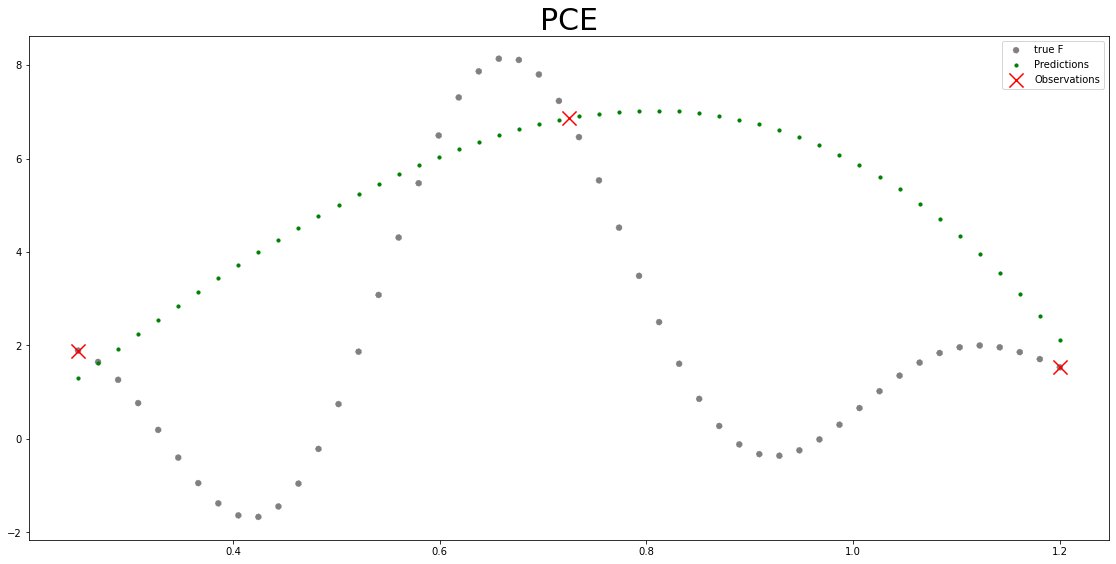

In [5]:
ntest=50

X1 = np.linspace(-1,1,ntest)
# X1=np.random.uniform(-1,1,ntest)
X1r=scalelegendre(X1,x1min,x1max)

# X1=np.random.normal(0,1,ntest)
# X1r=scalehermite(X1,x1mean,x1sigma)

# MSE=np.sum((Mtest-M)**2)
# print(MSE)
# print(Y_[0],np.mean(Mtest))
# %matplotlib notebook 

Mtest=function(X1r)
M=PCE(X1,Y)
# M=PCE(X1,p,M1,Y)

#Error estimator - Leave-one-out cross validation (ELOO)
hiMat=np.matmul(A,Inv_Trans)

Sum=0
for i in range(0,n):
    Sumi=((y[i]-M[i])/(1-hiMat[i,i]))**2
    Sum=Sum+Sumi
ELOO=Sum/n
print(ELOO)

fig = plt.figure(figsize=(15,7))
ax=fig.add_axes([0,0,1,1])
ax.scatter(X1r,Mtest,label=r"true F",linestyle='dashed',linewidth=0.5,color='grey')
ax.scatter(X1r,M,label=r"Predictions",color='g',s=10)
plt.scatter(x1r, y, label="Observations",marker="x",color='r', s=200)
plt.legend(prop={'size': 10})
plt.title(label="PCE",fontsize=30)
# plt.xlim([0, 1.3])

# Kriging Model

In [6]:
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-10, 1e5))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100)
gaussian_process.fit(x1r.reshape(-1,1), y.reshape(-1,1))
gaussian_process.kernel_

4.03**2 * RBF(length_scale=0.332)

In [176]:
# [KrigMean,variaDiag]=GaussianPred(t2,xn,M,A,Y)
# meanpred=PC+KrigMean.reshape(-1,1)

In [7]:
# kernel hyperparameters------------------------
l=0.332     #0.184
sig=4.03**2  #0.1**2
# KRIGING Predictions---------------------------
# meanpred=np.zeros([n])
# KRIGING mean-----------------------------------
COV_nn=euclid(distance(x1r,x1r),l,sig)           # R  correlation between observed points
COV_xn=euclid(distance(X1r,x1r),l,sig)           # r'(x)  correlation, new points with observations
COV_mult=np.matmul(COV_xn,np.linalg.inv(COV_nn))   #  r'(x) * R^-1
FB=np.matmul(A,Y)
KrigMean=np.matmul(COV_mult,(y-FB)) #.reshape(-1,1)
meanpred=M+KrigMean
# KRIGING variance-------------------------------
COV_xx=euclid(distance(X1r,X1r),l,sig)
variance=np.subtract(COV_xx,np.matmul(COV_mult,COV_xn.transpose())) #
variaDiag=np.diagonal(variance) #.reshape(-1,1)

In [10]:
z=0     #target value
# eff0=EFF(meanpred,variaDiag,z)
eff1 = np.zeros((ntest))
eff1=EFF1(meanpred,variaDiag,z)
# ynew=np.argmax(eff1)
# xnew=meanpred(ynew)

<ipython-input-1-3808b1fc10d6>:82: RuntimeWarning: divide by zero encountered in true_divide
  return ((u-z)*( 2*norm.cdf((z-u)/v) - norm.cdf((zl-u)/v) - norm.cdf((zh-u)/v))
<ipython-input-1-3808b1fc10d6>:83: RuntimeWarning: divide by zero encountered in true_divide
  -(v)*( 2*norm.pdf((z-u)/v) - norm.pdf((zl-u)/v) - norm.pdf((zh-u)/v))
<ipython-input-1-3808b1fc10d6>:84: RuntimeWarning: divide by zero encountered in true_divide
  +(2*v)*(norm.cdf((zh-u)/v) - norm.cdf((zl-u)/v)))


In [11]:
eff1

array([0.00000000e+000, 0.00000000e+000, 1.64441350e-065, 3.96423879e-017,
       1.93061171e-007, 2.67803086e-004, 5.91831759e-003, 2.83342460e-002,
       6.72005132e-002, 1.08175748e-001, 1.34877028e-001, 1.37200523e-001,
       1.14517427e-001, 7.57851551e-002, 3.64297092e-002, 1.06040491e-002,
       1.28072977e-003, 2.78930051e-005, 1.46878033e-008, 7.99265568e-016,
       1.24857618e-034, 2.09776271e-095, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       8.00768583e-104, 1.30634981e-038, 4.92625404e-018, 6.16858217e-010,
       3.20460883e-006, 2.59564901e-004, 3.00671539e-003, 1.26564046e-002,
       2.97120405e-002, 4.78902085e-002, 5.85759657e-002, 5.64792893e-002,
       4.25278823e-002, 2.34441385e-002, 8.07171366e-003, 1.20129628e-003,
       3.04685756e-005, 8.07365213e-009, 3.88715585e-019, 6.81317223e-066,
       0.00000000e+000, 0.00000000e+000])

Text(0.5, 1.0, 'PCE _ Kriging')

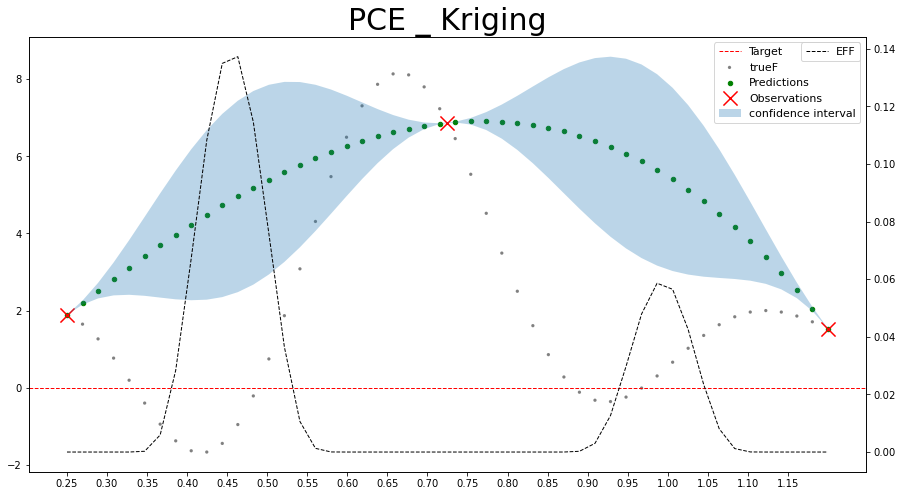

In [12]:
ymin=(meanpred - 1.5*variaDiag) #.reshape(-1,1)
ymax=(meanpred + 1.5*variaDiag) #.reshape(-1,1)

# sorting in case of random samples for ploting
# ind=np.argsort(np.squeeze(X1r))
# a,b,c=np.asarray(X1r)[ind], np.asarray(ymin)[ind], np.asarray(ymax)[ind]

#%matplotlib notebook 
fig, ax1 = plt.subplots(figsize=(15,8))

ax2=ax1.twinx()

ax1.scatter(X1r,Mtest,label=r"trueF",linestyle='dashed',linewidth=0.1,s=10,color='grey')
ax1.scatter(X1r,meanpred,label=r"Predictions",color='g',marker="o",s=20)
ax1.scatter(x1r, y, label="Observations",marker="x",color='r',s=200)
ax1.fill_between(
    X1r.ravel(),
    ymin.ravel(),
    ymax.ravel(),
#     a.ravel(),
#     b.ravel(),
#     c.ravel(),
    alpha=0.3,
    label=r"confidence interval",
)

# ax2.plot(X1r,eff0,label="EFF",linestyle='dashed',linewidth=1,color='k')
ax2.plot(X1r,eff1,label="EFF",linestyle='dashed',linewidth=1,color='k')

ax1.axhline(y=0.0,label="Target", color='red', linestyle='dashed',linewidth=1)
ax1.legend(prop={'size': 11})
ax2.legend(prop={'size': 11})
# plt.xlim([0.3, 0.9])
# plt.ylim([-0.1, 0.1])
plt.xticks(np.arange(min(X1r), max(X1r), 0.05))
plt.title(label="PCE _ Kriging",fontsize=30)

max point

In [289]:
xrnew=X1r[np.argmax(eff1)]
print(xrnew)

0.9673469387755101


Add a new observation 

In [290]:
#xrnew=0.99   #point in real x axis

#updating the related parameters

xnew=(2)*((xrnew-x1min)/(x1max-x1min))+(-1)      #point in (-1,1) range

x1 = np.append(x1,xnew)
x1r = np.append(x1r,xrnew)

y=function(x1r) 
n=len(x1r)

U Function

# LeaveOneOut_CrossValidation

In [7]:
# xhe=xleg
PC_loo=np.zeros(n)
KrigMeanloo=np.zeros(n)
KrigVarloo=np.zeros(n)
PC_looALL=np.zeros((n,ntest))
KrigMeanlooALL=np.zeros((n,ntest))
KrigVarlooALL=np.zeros((n,ntest))

for i in range (0,n):
    M_loo=np.delete(M,[i])          #y_n-i     leaving element i out the observations (M)
    xhe_loo=np.delete(xhe,[i])      #xhe_n-i   leaving element i out the hermite inputs (xi)
    xn_loo=np.delete(xn,[i])        #x_n-i     leaving element i out the inputs (xi)

    #Sampling matrix (F matrix) evaluation of the samples in a sparse p polynomials matrix from PCE
    F_loo = np.zeros((n-1, degree+1))
    B_loo = np.zeros((degree+1,1))
    n_loo = len (F_loo)
    
    for j in range (0,n_loo):
        for k in range (0,degree+1):
            F_loo[j,k] = np.array([poly(xhe_loo[j],k)])
            
    #Learning coefficients by Least-Square Minimization
    Ftrans=F_loo.transpose()
    Inv=np.linalg.inv(np.matmul(Ftrans, F_loo))
    Inv_Trans=np.matmul(Inv,Ftrans)
    B_loo=np.matmul(Inv_Trans,M_loo)                #B coefficients for PC =f(M_loo) observations
    
    # PCE mean prediction --------------leaving i-term out
    PC_loo[i]=PCE([xhe[i]],degree,poly,B_loo)   #following coefficients B
    PC_looALL[i]=np.squeeze(PCE(tleg2,degree,poly,B_loo))
    
    # KRIGING mean--------------leaving i-term out
    [KrigMeanloo[i],KrigVarloo[i]]=GaussianPred(xn[i],xn_loo,M_loo,F_loo,B_loo)    #following coefficients B
    [KrigMeanlooALL[i],KrigVarlooALL[i]]=GaussianPred(t2,xn_loo,M_loo,F_loo,B_loo)
    
mean_loo=PC_loo+KrigMeanloo
e_loo=(M-mean_loo)**2
sumat=np.divide(e_loo,KrigVarloo)
mean_looALL=PC_looALL+KrigMeanlooALL

LOOCV=np.zeros(predict)
cell=np.zeros(predict)
for k in range (0,predict):  
    voro = VoronoiCell(t2[k],xn)
    LOOCV[k]= variaDiag[k]*(1+sumat[voro])
#     cell[k] = voro

Text(0, 0.5, 'Quantity of Interest (QoI)')

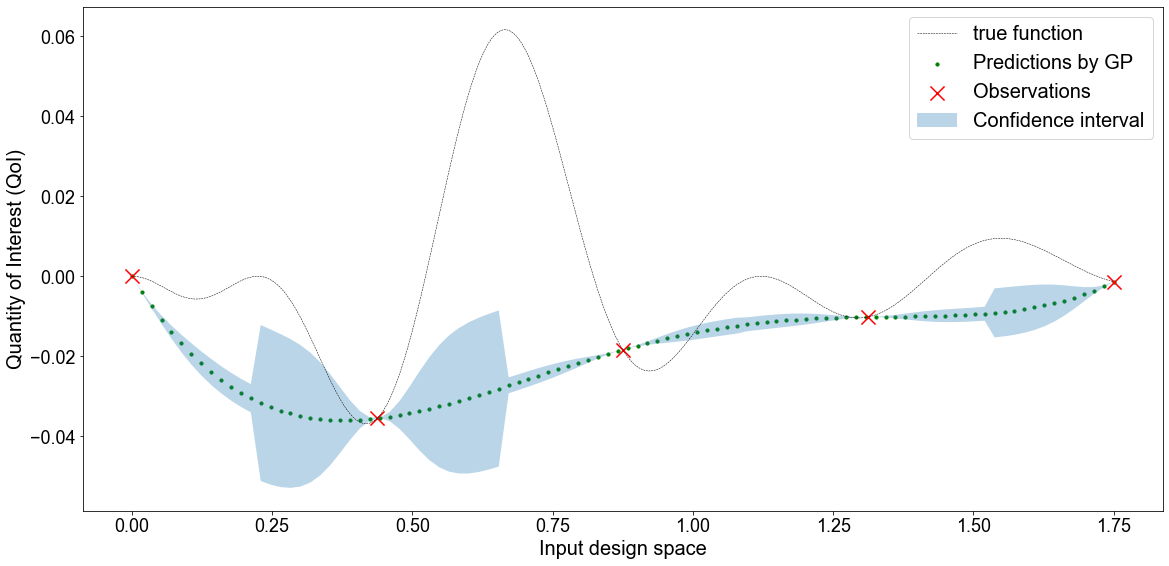

In [23]:
yminloo=(meanpred - 1.0*LOOCV.reshape(-1,1))
ymaxloo=(meanpred + 1.0*LOOCV.reshape(-1,1))
# hfont = {'fontname':'Arial'}
plt.rcParams.update({'font.family':'Arial'})

size=20

nloo=1   #to check the shape of the n-loo predictors
#sorting in case of random samples for ploting variance (fill between)
# indp=np.argsort(np.squeeze(t2))
ap,bp,cp=np.asarray(t2)[ind], np.asarray(yminloo)[ind], np.asarray(ymaxloo)[ind]

Varimax= np.argmax(cp-bp)
xnew=ap[Varimax]
ynew=function(xnew)

fig = plt.figure(figsize=(15,7))
ax=fig.add_axes([0,0,1,1])
ax.plot(t,y,label=r"true function",linestyle='dashed',linewidth=0.5,color='k')
ax.scatter(t2,meanpred,label=r"Predictions by GP",color='g',s=10)
# ax.scatter(xn,mean_loo,label=r"Prediction LOOCV",color='y',s=200,marker="+")
plt.scatter(xn, M, label="Observations",marker="x",color='r',s=200)

# ax.scatter(t2,mean_looALL[nloo],label=r"Prediction LOO-ALL",color='y',s=20,marker="+")
# ax.scatter(t2,KrigMeanlooALL[nloo],label=r"Prediction KrigALL",color='#17becf',s=20,marker="*")
# ax.scatter(t2,PC_looALL[nloo],label=r"Prediction PCEALL",color='#1f77b4',s=20,marker="x")

# plt.scatter(xnew,ynew,label="NewPoint",marker="o",color='r',s=200)

plt.fill_between(
    ap.ravel(),
    bp.ravel(),
    cp.ravel(),
    alpha=0.3,
    label=r"Confidence interval",
)
plt.legend(prop={'size': size})
plt.tick_params(axis='x', labelsize=size*0.9)
plt.tick_params(axis='y', labelsize=size*0.9)
plt.xlabel('Input design space', fontsize=size)
plt.ylabel('Quantity of Interest (QoI)', fontsize=size)
# plt.xlim([0, 2.5])
# plt.ylim([-3, 5])
# plt.title(label="PCE _ Kriging _LOO CV",fontsize=30)